# Preprocess and window longitudinal datasets and save afterwards

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [3]:
import os

In [4]:
import pickle

In [5]:
from decode_tueg import (
    get_longitudinal_ds, preprocess, get_preprocessors,
    _create_windows, _create_final_scores, load_exp,
    get_n_preds_per_input, DataScaler, TargetScaler,
    Augmenter,
)

Mon Feb  6 13:25:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 22%   51C    P8    17W / 250W |      4MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
exp_date = '2023-02-03T22:27:26.056071'

In [7]:
exp_dir = '/home/jovyan/experiments/'

In [8]:
mapping = None  # where to get this from?
pred_path = '/home/jovyan/'
checkpoint = 'train_end'

In [9]:
seed = str(20230203)
run = str(0)

In [10]:
estimator, data_scaler, target_scaler, config = load_exp(
    exp_dir, os.path.join(exp_date, seed, run), checkpoint)

In [11]:
min_age = int(config.min_age)
max_age = int(config.max_age)
tmin = -1#int(config.tmin)
tmax = -1#int(config.tmax)
n_jobs = int(config.n_jobs)
window_size_samples = int(config.window_size_samples)
preload = int(config.preload)
target_name = config.target_name
out_dir = config.out_dir

In [ ]:
for ds_name in ['pathological', 'non_pathological', 'transition']:
    print('getting')
    ds = get_longitudinal_ds(ds_name, (min_age, max_age))
    print('preprocessing')
    ds = preprocess(
        ds, 
        preprocessors=get_preprocessors(tmin, tmax), 
        n_jobs=n_jobs,
    )
    n_preds_per_input = get_n_preds_per_input(
        estimator.module, ds[0][0].shape[0], window_size_samples)
    print('windowing')
    ds = _create_windows(
        ds,
        window_size_samples,
        n_jobs, 
        preload,
        n_preds_per_input,
        mapping,
    )
    with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'wb') as f:
        pickle.dump(ds, f)

# Predict the longitudinal datasets

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
from decode_tueg import (
    deconfound, load_exp, _create_final_scores, plot_age_gap_hist, plot_heatmaps,
    save_csv, plot_age_gap_hist_and_permutation_test, DataScaler, TargetScaler,
    Augmenter, iter_exp_dir,
)

Wed Feb  8 11:27:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:89:00.0 Off |                  N/A |
| 27%   30C    P8     8W / 250W |   2936MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-07T06:28:03.373666'
checkpoint = 'train_end'

In [5]:
n_recordings = 100

In [6]:
# read all experiment models (seeds and cv / eval runs) to predict longitudinal datasets
for ds_name in ['transition', 'non_pathological', 'pathological']: 
#    seeds = sorted(os.listdir(os.path.join(exp_dir, exp_date)))
#    for seed in seeds:
#        runs = sorted(os.listdir(os.path.join(exp_dir, exp_date, seed)))
#        for run_i, run in enumerate(runs):
#            exp_path = os.path.join(exp_date, seed, run)
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(f'loading exp {exp_path}')
        estimator, data_scaler, target_scaler, config = load_exp(
            exp_dir, exp_path, checkpoint)
        print(f'getting {ds_name}')
        with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
            ds = pickle.load(f)
        if n_recordings not in [-1, None]:
            ds = ds.split(list(range(n_recordings)))['0']
        print('predicting')
        ds_preds, ds_score = _create_final_scores(
            estimator,
            ds,
            ds_name,
            config.target_name,
            target_scaler,
            data_scaler,
            int(config.n_jobs),
            subject_wise=True,
        )
        save_path = os.path.join(exp_dir, exp_path, 'preds')
        print(f'saving {save_path}')
        # write preds to file
        save_csv(
            ds_preds,
            save_path,
            f'{checkpoint}_longitudinal_{ds_name}_preds.csv',
        )
        # write scores to file
        scores = pd.read_csv(
            os.path.join(os.path.join(exp_dir, exp_path), f'{checkpoint}_scores.csv'), 
            index_col=0,
        )
        for k, v in ds_score.items():
            scores[k] = v
        save_csv(
            scores,
            os.path.join(exp_dir, exp_path),
            f'{checkpoint}_scores.csv',
        )

loading exp 2023-02-07T06:28:03.373666/20230206/0
getting transition
predicting
2023-02-08 11:27:47 INFO     on transition reached
2023-02-08 11:28:10 INFO     14.61 mae
2023-02-08 11:28:10 INFO     17.15 mdae
2023-02-08 11:28:10 INFO     0.21 r2
2023-02-08 11:28:10 INFO     0.37 mape
2023-02-08 11:28:10 INFO     0.27 mdape
saving /home/jovyan/experiments/2023-02-07T06:28:03.373666/20230206/0/preds
loading exp 2023-02-07T06:28:03.373666/20230206/1
getting transition
predicting
2023-02-08 11:28:14 INFO     on transition reached
2023-02-08 11:28:36 INFO     14.28 mae
2023-02-08 11:28:36 INFO     15.75 mdae
2023-02-08 11:28:36 INFO     0.24 r2
2023-02-08 11:28:36 INFO     0.34 mape
2023-02-08 11:28:36 INFO     0.30 mdape
saving /home/jovyan/experiments/2023-02-07T06:28:03.373666/20230206/1/preds
loading exp 2023-02-07T06:28:03.373666/20230206/2
getting transition
predicting
2023-02-08 11:28:41 INFO     on transition reached
2023-02-08 11:29:03 INFO     13.43 mae
2023-02-08 11:29:03 INFO  

In [7]:
print("hi")

hi


# Read the longitudinal predictions and plot them

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [2]:
import pandas as pd

In [3]:
from decode_tueg import (
    deconfound, plot_age_gap_hist, plot_heatmaps,
    plot_age_gap_hist_and_permutation_test, iter_exp_dir,
)

Wed Feb  8 11:16:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:89:00.0 Off |                  N/A |
| 46%   54C    P2    78W / 250W |   2936MiB / 11264MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-07T06:28:03.373666'
checkpoint = 'train_end'

In [7]:
for exp_path in iter_exp_dir(exp_dir, exp_date):
    break

In [18]:
for ds_name in ['transition', 'non_pathological', 'pathological']:
    break

In [19]:
preds_path = os.path.join(exp_dir, exp_path, 'preds', f'{checkpoint}_{ds_name}_preds.csv')

In [17]:
preds = pd.read_csv(preds_path, index_col=0)

In [ ]:
if int(config.final_eval) == 0:
    # in cv append all predictions
    preds = pd.concat(all_ds_preds, ignore_index=True)
else:
    # in fe average all predictions
    # TODO: make sure not averaing wrong stuff
    raise NotImplementedError
    all_targets = [df.y_true for df_i, df in all_ds_preds.items()]
    # average preds and write back
    all_preds = [df.y_pred for df_i, df in all_ds_preds.items()]
    preds = all_ds_preds[0]
    preds['y_pred'] = np.mean(all_preds, axis=0)

In [9]:
bin_width = 2
n_repetitions = 10000  # actually 100000!
max_age = 100
detrend = 'quadratic'

<AxesSubplot: xlabel=' ', ylabel='Count'>

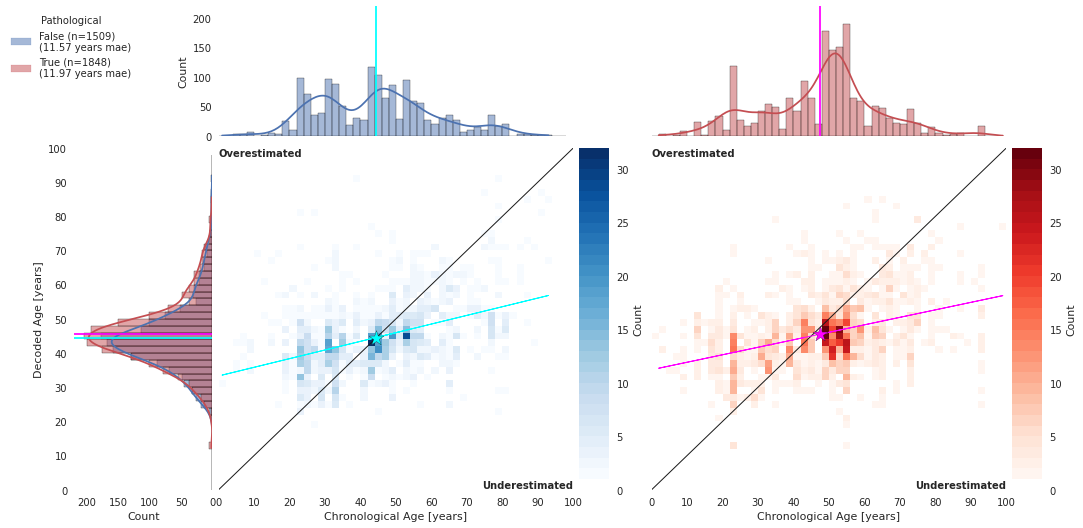

In [10]:
plot_heatmaps(preds, bin_width, max_age, hist_max_count=220)

In [11]:
# TODO: observed not diff of means. why?

observed age gap diff 0.3420536999190569


<AxesSubplot: xlabel='Decoded Age – Chronological Age [years]', ylabel='Count'>

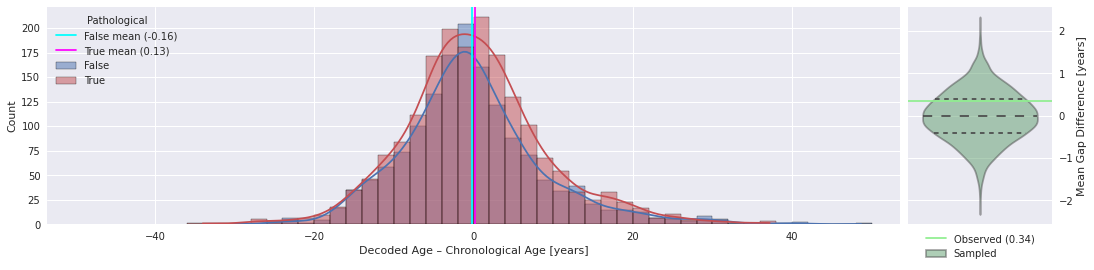

In [12]:
plot_age_gap_hist_and_permutation_test(deconfound(preds, detrend), bin_width, n_repetitions)

In [15]:
from decode_tueg import reject_derivating_ages

In [16]:
for ds_i, ds_ in enumerate(ds.datasets):
    break

In [18]:
_ = [ds_.set_description(
    {'path': ds_.description['path'].replace(
        '/data/datasets/TUH/EEG/tuh_eeg', '/home/jovyan/mne_data/TUH/tuh_eeg/')},
    overwrite=True,
) for ds_i, ds_ in enumerate(ds.datasets)]